In [2]:
import pyspark
from pyspark.sql import SparkSession
import numpy as np
import pandas as pd
from pyspark.ml.recommendation import ALS
from pyspark.sql.types import *
import matplotlib.pyplot as plt
plt.style.use("ggplot")

In [3]:
spark = SparkSession.builder.master("local[2]").getOrCreate()
sc = spark.sparkContext

In [53]:
df=spark.read.csv("data/completed.csv", header=True)
df=df.select(df['username'].cast('int'),df['anime_id'].cast('int'),df['score'].cast('float'))
df=df.na.drop()
df.printSchema()

df.createOrReplaceTempView("table")
df = spark.sql('''
    select username, anime_id, case
        when score = 0
            then 74
        when score > 100 
            then 100
        else score
    end 
    as score
    from table    
    ''')
df.show()

root
 |-- username: integer (nullable = true)
 |-- anime_id: integer (nullable = true)
 |-- score: float (nullable = true)

+--------+--------+-----+
|username|anime_id|score|
+--------+--------+-----+
|       1|       1| 60.0|
|       1|      30| 85.0|
|       1|      32| 85.0|
|       1|      79| 60.0|
|       1|     226| 35.0|
|       1|     227| 60.0|
|       1|     339| 60.0|
|       1|     356| 60.0|
|       1|     433| 35.0|
|       1|     759| 85.0|
|       1|     770| 85.0|
|       1|     889| 60.0|
|       1|    1195| 60.0|
|       1|    1535| 60.0|
|       1|    1575| 60.0|
|       1|    1689| 85.0|
|       1|    1943| 85.0|
|       1|    2001| 60.0|
|       1|    2167| 35.0|
|       1|    2236| 60.0|
+--------+--------+-----+
only showing top 20 rows



In [54]:
df.describe().show()

+-------+-----------------+-----------------+----------------+
|summary|         username|         anime_id|           score|
+-------+-----------------+-----------------+----------------+
|  count|          6294391|          6294391|         6294391|
|   mean|33073.78466590334|9977.269728556743|73.9951499676458|
| stddev|28598.69684457631| 8720.46218979115|15.6648785756638|
|    min|                1|                1|             1.0|
|    max|            96981|            99217|           100.0|
+-------+-----------------+-----------------+----------------+



In [55]:
df.createOrReplaceTempView("table")
df = spark.sql('''
    with avg_u as (
    select username, avg(score) as avg_for_user
    from table
    group by username
    ), 
    avg_s as (
    select anime_id, avg(score) as avg_for_show
    from table 
    group by anime_id
    )
    select t.username, t.anime_id, t.score-avg_u.avg_for_user-avg_s.avg_for_show+74 as score, 
    avg_u.avg_for_user, avg_s.avg_for_show
    from table t 
    join avg_u 
    on t.username = avg_u.username
    join avg_s
    on t.anime_id = avg_s.anime_id
    order by score
    ''')
df.show()

+--------+--------+-------------------+-----------------+-----------------+
|username|anime_id|              score|     avg_for_user|     avg_for_show|
+--------+--------+-------------------+-----------------+-----------------+
|   62311|    7311| -109.5495594240275|98.53333333333333|86.01622609069418|
|   62311|   21087|-106.39378408973963|98.53333333333333| 82.8604507564063|
|   20306|   11061| -98.98285483519365|95.58282208588957|87.40003274930407|
|   79373|    5114| -96.89014445053942|92.46666666666667|88.42347778387274|
|   50237|   11061| -95.35807470734602|91.95804195804196|87.40003274930407|
|    2221|    2001| -95.08034025223333|94.20454545454545|84.87579479768786|
|   59693|   18617| -94.99803493989955|99.16820702402957|79.82982791586998|
|   77043|    1535|  -94.5094758316107|86.88888888888889|82.62058694272181|
|   72606|   16498| -94.35678005451916|96.65917602996255|81.69760402455661|
|   56981|     205| -93.52434473469208| 95.4090909090909|82.11525382560117|
|    8461|  

In [57]:
df_train, df_test = df.randomSplit([0.8, 0.2])
# print df_train.count()
# print df_test.count()

In [59]:
df.show()


+--------+--------+-------------------+-----------------+-----------------+
|username|anime_id|              score|     avg_for_user|     avg_for_show|
+--------+--------+-------------------+-----------------+-----------------+
|   62311|    7311| -109.5495594240275|98.53333333333333|86.01622609069418|
|   62311|   21087|-106.39378408973963|98.53333333333333| 82.8604507564063|
|   20306|   11061| -98.98285483519365|95.58282208588957|87.40003274930407|
|   79373|    5114| -96.89014445053942|92.46666666666667|88.42347778387274|
|   50237|   11061| -95.35807470734602|91.95804195804196|87.40003274930407|
|    2221|    2001| -95.08034025223333|94.20454545454545|84.87579479768786|
|   59693|   18617| -94.99803493989955|99.16820702402957|79.82982791586998|
|   77043|    1535|  -94.5094758316107|86.88888888888889|82.62058694272181|
|   72606|   16498| -94.35678005451916|96.65917602996255|81.69760402455661|
|   56981|     205| -93.52434473469208| 95.4090909090909|82.11525382560117|
|    8461|  

In [56]:
df.describe().show()

+-------+-----------------+-----------------+--------------------+-----------------+-----------------+
|summary|         username|         anime_id|               score|     avg_for_user|     avg_for_show|
+-------+-----------------+-----------------+--------------------+-----------------+-----------------+
|  count|          6294391|          6294391|             6294391|          6294391|          6294391|
|   mean|33073.78466590334|9977.269728556743|0.004850032354201449|73.99514996764594|73.99514996764623|
| stddev|28598.69684457595|8720.462189791144|  11.988280360490846|8.542675692901128|6.180221605247429|
|    min|                1|                1|  -109.5495594240275|              1.0|              5.0|
|    max|            96981|            99217|   99.69836901121305|            100.0|            100.0|
+-------+-----------------+-----------------+--------------------+-----------------+-----------------+



In [64]:
als_model = ALS(
    itemCol='anime_id',
    userCol='username',
    ratingCol='score',
    nonnegative=False,
    regParam=0.2,
    rank=10
)

In [65]:
recommender = als_model.fit(df)

In [8]:
test_input = df_test.select(df_test['username'],df_test['anime_id'])

In [9]:
predictions = recommender.transform(test_input)
predictions = predictions.join(df_test, (predictions.username==df_test.username) & (predictions.anime_id==df_test.anime_id))
predictions.show()

+--------+--------+----------+--------+--------+-----+
|username|anime_id|prediction|username|anime_id|score|
+--------+--------+----------+--------+--------+-----+
|       5|    3298| 80.556885|       5|    3298| 80.0|
|       6|     117| 79.384995|       6|     117| 90.0|
|       8|    9062| 82.154755|       8|    9062| 90.0|
|      13|     462| 60.253754|      13|     462| 60.0|
|      14|    1401|  74.83783|      14|    1401| 80.0|
|      20|   18295| 12.973517|      20|   18295|  0.0|
|      24|    6288| 47.840836|      24|    6288| 30.0|
|      38|   11597|  80.29285|      38|   11597| 90.0|
|      40|    2759|  73.63997|      40|    2759| 90.0|
|      40|    7059| 47.791058|      40|    7059| 50.0|
|      40|    9379|  58.88542|      40|    9379| 70.0|
|      40|   10790|  54.79515|      40|   10790| 50.0|
|      48|   17725|  65.07671|      48|   17725| 70.0|
|      51|     514|  65.74366|      51|     514| 70.0|
|      54|    2970| 49.763332|      54|    2970| 50.0|
|      56|

In [10]:
compare=predictions.select(predictions['prediction'], predictions['score'])
compare=compare.na.fill(0)
compare.describe().show()

+-------+------------------+------------------+
|summary|        prediction|             score|
+-------+------------------+------------------+
|  count|           1261846|           1261846|
|   mean|56.629538468743775|56.609954780535816|
| stddev|  30.2918992290304| 35.27210721221575|
|    min|               0.0|               0.0|
|    max|          310.9843|             255.0|
+-------+------------------+------------------+



In [11]:
compare.createOrReplaceTempView("Predictions")
result = spark.sql('''
    SELECT AVG((prediction-score)*(prediction-score)) as MSE
    FROM Predictions
    ''')
result.show()

+------------------+
|               MSE|
+------------------+
|276.69765411913437|
+------------------+



In [13]:
result.collect()[0][0]

335.99033126098215

In [66]:
U=sorted(recommender.userFactors.collect())

In [67]:
V=sorted(recommender.itemFactors.collect())

In [75]:
V[9295]

Row(id=21742, features=[0.5803225040435791, 3.546067476272583, 1.9373228549957275, 0.3253227770328522, -4.630452632904053, 0.5513330101966858, -1.3241522312164307, 0.1322772055864334, -1.5392627716064453, 2.874828338623047])

In [69]:
import csv

In [70]:
with open('spark_V.csv', 'w') as csv_file:
    c1=csv.writer(csv_file, delimiter=',')
    c1.writerow(['col1','col2','col3','col4','col5','col6','col7','col8','col9','col10'])
    csv_file.close()

In [71]:
with open('id_mapping.csv', 'w') as csv_file:
    c1=csv.writer(csv_file, delimiter=',')
    c1.writerow(['col1'])
    csv_file.close()

In [73]:
with open('spark_V.csv', 'a') as csv_file:
    c1=csv.writer(csv_file, delimiter=',')
    for i in range(len(V)):
        c1.writerow(V[i][1])
    csv_file.close()
    

In [74]:
with open('id_mapping.csv', 'a') as csv_file:
    c1=csv.writer(csv_file, delimiter=',')
    for i in range(len(V)):
        c1.writerow([V[i][0]])
    csv_file.close()

In [62]:
def grid_search_plot():
    x_axis=[]
    y_axis=[]
    for k in range(1,10):
        x_axis.append(0.2*k)
        als_model = ALS(
            itemCol='anime_id',
            userCol='username',
            ratingCol='score',
            nonnegative=True,
            regParam=0.2*k,
            rank=10
        )
        recommender = als_model.fit(df_train)
        test_input = df_test.select(df_test['username'],df_test['anime_id'])
        predictions = recommender.transform(test_input)
        predictions = predictions.join(df_test, (predictions.username==df_test.username) & (predictions.anime_id==df_test.anime_id))
        compare=predictions.select(predictions['prediction'], predictions['score'])
        compare=compare.na.fill(0)
        compare.createOrReplaceTempView("Predictions")
        result = spark.sql('''
            SELECT AVG((prediction-score)*(prediction-score)) as MSE
            FROM Predictions
            ''')
        MSE=result.collect()[0][0]
        y_axis.append(MSE)
        print k, MSE
    x_axis=np.array(x_axis)
    y_axis=np.array(y_axis)
    fig, ax = plt.subplots()
    ax.plot(x_axis, y_axis)
    plt.show()


In [63]:
grid_search_plot()

1 126.904492457
2 127.644800272
3 129.331293189
4 130.969570868
5 132.596936604


KeyboardInterrupt: 

16 336.734638183
17 337.97129506
18 337.254028785
19 338.254838945


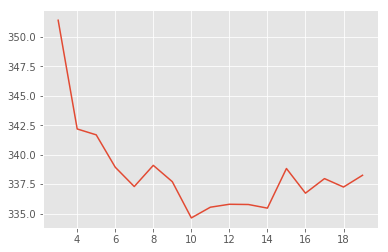

In [42]:
x_axis=[3,4,5,6,7,8,9,10,11,12,13,14,15]
y_axis=[351.43, 342.19, 341.69, 338.94, 337.297, 339.097, 337.71, 334.63, 335.54, 335.79, 335.77,335.462, 338.83]
grid_search_plot(x_axis, y_axis)

In [76]:
df1=spark.read.csv("data/completed.csv", header=True)
df1=df1.select(df1['username'].cast('int'),df1['anime_id'].cast('int'),df1['score'].cast('float'))
df1=df1.na.drop()

df1.createOrReplaceTempView("table1")
df1 = spark.sql('''
    select username, anime_id, case
        when score = 0
            then 74
        when score > 100 
            then 100
        else score
    end 
    as score
    from table    
    ''')
df1.show()

+--------+--------+-----+
|username|anime_id|score|
+--------+--------+-----+
|       1|       1| 60.0|
|       1|      30| 85.0|
|       1|      32| 85.0|
|       1|      79| 60.0|
|       1|     226| 35.0|
|       1|     227| 60.0|
|       1|     339| 60.0|
|       1|     356| 60.0|
|       1|     433| 35.0|
|       1|     759| 85.0|
|       1|     770| 85.0|
|       1|     889| 60.0|
|       1|    1195| 60.0|
|       1|    1535| 60.0|
|       1|    1575| 60.0|
|       1|    1689| 85.0|
|       1|    1943| 85.0|
|       1|    2001| 60.0|
|       1|    2167| 35.0|
|       1|    2236| 60.0|
+--------+--------+-----+
only showing top 20 rows



In [77]:
df1.createOrReplaceTempView("table1")
result = spark.sql('''
    select anime_id, avg(score) as avg_for_show
    from table1
    group by anime_id
    order by anime_id
    ''')
result.show()

+--------+-----------------+
|anime_id|     avg_for_show|
+--------+-----------------+
|       1|85.09464373464374|
|       5|80.69470198675496|
|       6|79.88804945054945|
|       7|71.70194003527337|
|       8|70.01530612244898|
|      15| 77.3578431372549|
|      16| 79.7933010136624|
|      17| 74.8395061728395|
|      18|79.95949367088608|
|      19|86.11089494163424|
|      20|74.01059306229018|
|      21|80.31979695431473|
|      22|78.16957306073361|
|      23|           68.675|
|      24|77.70599666851749|
|      25|72.29283771532185|
|      26|77.75950349107835|
|      27|71.87989417989418|
|      28|77.38314944834504|
|      29|            70.38|
+--------+-----------------+
only showing top 20 rows



In [82]:
result.toPandas().to_csv('avg_show_R.csv')